In [1]:
import numpy
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
import math
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
 
# tensorflow.reset_default_graph()
tensorflow.random.set_seed(0)
# random.seed(0)
numpy.random.seed(0)

In [2]:
def create_dataset(dataset, look_back=14, day_offset=5):
    dataX, dataY= [],[]
    dataX=numpy.zeros([(len(dataset)-look_back),2,look_back])
    
    #print(dataX.shape)
    for i in range(look_back,len(dataset)):
       # print(i)
        a = numpy.zeros([2,look_back])
        t1=dataset[(i-look_back):i, 0]
        t1=numpy.reshape(t1,[1,look_back])
        t4=dataset[(i-look_back):i, 48]
        t4=numpy.reshape(t4,[1,look_back])
        #print(t1.shape)
#         t2=dataset[i, 48-look_back:48]
#         t2=numpy.reshape(t2,[1,look_back])
#         t6=dataset[i,-(look_back+3):-3]
#         t6=numpy.reshape(t6,[1,look_back])
#         t3=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t3[0,0:day_offset]=[dataset[j,0] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
#         t5=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t5[0,0:day_offset]=[dataset[j,48] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
            
            
        #print(t2.shape)
        a[0,:] = t1
        a[1,:] = t4
#         a[2,:] = t2
#         a[3,:] = t6
        
        dataX[i-look_back,:,:]=a
#         a = numpy.concatenate([dataset[(i-look_back-7):i-7, 0], dataset[i,-14:]],axis=1)
        
        #dataX.append(a)
        dataY.append(dataset[i,-1])
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
def missing_values(datarange, categorical=[]):  
    datarange= pd.DataFrame(datarange)
    if not categorical:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
    else:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
        
        modedata = datarange.mode()
        modedata = modedata.to_numpy()
        modedata = modedata[0,:]
        
        for i in categorical:
                meandata[i-1] = modedata[i]
                
    datetime_series = pd.to_datetime(datarange['fltdat'])
    miss_idx=pd.date_range(start = '01-01-2015', end = '31-12-2019' ).difference(datetime_series)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    datarange=datarange.set_index(datetime_index)

    datarange.drop('fltdat',axis=1,inplace=True)
    newidx = pd.date_range('01-01-2015', '31-12-2019')
    datarange = datarange.reindex(newidx, fill_value=0)
    
    meandata=meandata.reshape(1,meandata.shape[0])
    dat = numpy.tile(meandata, [miss_idx.shape[0],1])
    datarange.loc[miss_idx]=dat
    return datarange

In [4]:
def mean_absolute_percentage_error(y_test, y_pred):
        import numpy as np
        t = np.array(y_test)
        p = np.array(y_pred)
        mae = list()
        mape = list()
        for i in range(len(t)):
            if (t[i] == 0):
                mae.append(abs(p[i]))
            else:
                mae.append(float(abs(t[i] - p[i])))
                mape.append(float(abs((t[i] - p[i])/t[i])))
        return np.mean(mae) , np.mean(mape)

In [5]:
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('data/rmscapfc.csv', parse_dates=['fltdat'],dayfirst=True)
print(dataframe.columns)
dataframe.drop(dataframe.columns[[2,3,4,6,8,9,10,56,57,58,59,60,61,62] ], axis=1, inplace=True)

dataframe2 = read_csv('data/rmscapy.csv', parse_dates=['fltdat'],dayfirst=True)
# print(dataframe2.columns)
f_column = dataframe2[["paxcnty", "dcp_51", "dcp_50", "dcp_49", "dcp_48", "dcp_47", "dcp_46",
       "dcp_45", "dcp_44", "dcp_43", "dcp_42", "dcp_41", "dcp_40", "dcp_39",
       "dcp_38", "dcp_37", "dcp_36", "dcp_35", "dcp_34", "dcp_33", "dcp_3",
       "dcp_31", "dcp_30", "dcp_29", "dcp_28", "dcp_27", "dcp_26", "dcp_25",
       "dcp_24", "dcp_23", "dcp_22", "dcp_21", "dcp_20", "dcp_19", "dcp_18",
       "dcp_17", "dcp_16", "dcp_15", "dcp_14", "dcp_13", "dcp_12", "dcp_11",
       "dcp_10", "dcp_9", "dcp_8"]]
 

dataframe = pd.concat([dataframe,f_column], axis = 1)
# print(dataframe.columns)
dataframe3 = read_csv('data/uldfc.csv', parse_dates=['fltdat'],dayfirst=True)

dataframe3.drop(dataframe3.columns[[1,2,3] ], axis=1, inplace=True)
dataframe4 = read_csv('data/uldy.csv', parse_dates=['fltdat'],dayfirst=True)
dataframe4.drop(dataframe4.columns[[1,2,3] ], axis=1, inplace=True)
f_column = dataframe4[["county"]]
dataframe3 = pd.concat([dataframe3,f_column], axis = 1)
print(dataframe.columns)

Index(['fltdat', 'paxcntfc', 'fltnum', 'legorg', 'legdst', 'acrtypcod',
       'keyidr', 'totpaylodwgt', 'totpaylodvol', 'totpaylodpos', 'totsetfc',
       'totpaxwgt', 'dp_51', 'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46',
       'dp_45', 'dp_44', 'dp_43', 'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38',
       'dp_37', 'dp_36', 'dp_35', 'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30',
       'dp_29', 'dp_28', 'dp_27', 'dp_26', 'dp_25', 'dp_24', 'dp_23', 'dp_22',
       'dp_21', 'dp_20', 'dp_19', 'dp_18', 'dp_17', 'dp_16', 'dp_15', 'dp_14',
       'dp_13', 'dp_12', 'dp_11', 'dp_10', 'dp_9', 'dp_8', 'dp_7', 'dp_6',
       'dp_5', 'dp_4', 'dp_3', 'dp_2', 'dp_1'],
      dtype='object')
Index(['fltdat', 'paxcntfc', 'acrtypcod', 'totpaylodwgt', 'totpaxwgt', 'dp_51',
       'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46', 'dp_45', 'dp_44', 'dp_43',
       'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38', 'dp_37', 'dp_36', 'dp_35',
       'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30', 'dp_29', 'dp_28', 'dp_27',

In [6]:
NUM=[0,1825,1825,1817,1816,1812,1821,1825,1824,1819,1825,1825,1824,1826,1819,1825,1822,1823,1813, 1826, 1820]
NUMuld=[0,1817,1574,1808,1802,1807,1808,1730,1817,1385,1820,1816,1606,1819,1810,1817,421,1813,434,1532,1814]
cat_inp=[2]

In [7]:
# dataset, datasetY = numpy.empty([1805,3,look_back]), []
for i in range(0,len(NUM)-1):
#     print(i)
    datasub = dataframe.iloc[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasub = missing_values(datasub, cat_inp)
    datasub = datasub.values
    datasub = datasub.astype('float32')
    
    datasubuld = dataframe3.iloc[sum(NUMuld[0:i+1]):sum(NUMuld[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasubuld = missing_values(datasubuld)
    datasubuld = datasubuld.values
    datasubuld = datasubuld.astype('float32')
    
    datasub = numpy.concatenate([datasub, datasubuld], axis=1)
    if i==0:
        data = datasub
    else:
        data = numpy.concatenate([data, datasub], axis =0)
 

C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [8]:
out = data[:,2] - data[:,3] - (data[:,-1]*data[:,-2]*114)
out = out.reshape(out.shape[0],1)
data = numpy.concatenate([data,out], axis=1)
print(data.shape)

(36520, 96)


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

In [10]:
def sequence_data_build(data, look_back):
    for i in range(0,20):
        datasub = data[i*1826:((i+1)*1826),:]
        X, Y = create_dataset(datasub, look_back)
        Y = Y.reshape(Y.shape[0],1)
        if i==0: 
            data_LSTM_X = X
            data_LSTM_Y = Y
        else:
            data_LSTM_X = numpy.concatenate([data_LSTM_X, X],axis=0)
            data_LSTM_Y = numpy.concatenate([data_LSTM_Y, Y],axis=0)
    return data_LSTM_X, data_LSTM_Y

In [11]:
def train_test_build(X, Y, m1, m2):
    spliter = int(X.shape[0]/20)
    tot_len = m1
    train_len = m2
    for i in range(0,20):
        Xsub = X[i*1826:((i+1)*1826),:]
        Ysub = Y[i*1826:((i+1)*1826)]
        if i==0:
            trainX = Xsub[0:m2,:]
            testX = Xsub[m2:m1,:]
            trainY = Ysub[0:m2]
            testY = Ysub[m2:m1]
        else:
            trainX = numpy.concatenate([trainX, Xsub[0:m2,:]], axis=0)
            testX = numpy.concatenate([testX, Xsub[m2:m1,:]], axis=0)
            trainY = numpy.concatenate([trainY, Ysub[0:m2]], axis=0)
            testY = numpy.concatenate([testY, Ysub[m2:m1]], axis=0)
        
    return trainX, trainY, testX, testY

In [12]:
def model_build(trainX, trainY, testX, testY, units, saving =False, month=None, EarlyStop = False):
    if EarlyStop:
        callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                            mode = 'min', restore_best_weights=True)
    model = Sequential()
    model.add(LSTM(units, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    if EarlyStop:
        history = model.fit(trainX, trainY, epochs=100, batch_size=150, validation_data=(testX, testY),verbose=1,
                            callbacks=[callback])
    else:
        history = model.fit(trainX, trainY, epochs=100, batch_size=150, validation_data=(testX, testY),verbose=1, )#callbacks=[callback]
        
    testPredict = model.predict(testX)
                
    sh = testPredict.shape
    inv_yhat = testPredict.reshape(sh[0]*sh[1],1)
    inv_yhat = numpy.concatenate([ data[0:inv_yhat.shape[0],0:95], inv_yhat], axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]
    testY = testY.reshape(sh[0]*sh[1],1)
 
    inv_y = numpy.concatenate([data[0:testY.shape[0],0:95], testY], axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
             
    rmse = numpy.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae, mape = mean_absolute_percentage_error(inv_y, inv_yhat) 
    r2 = r2_score(inv_y, inv_yhat)
    
    res=[]
    if saving:
        inv_y = inv_y.reshape(inv_y.shape[0],1) 
        inv_yhat = inv_yhat.reshape(inv_yhat.shape[0],1) 
        res = numpy.concatenate([inv_y, inv_yhat], axis=1)
        df = pd.DataFrame(res)
        res = df.to_csv("ds_" + month + ".csv", index = False)
    return rmse, mape,mae,r2, history

In [13]:
def cross_validation(lag_vec = [7,14,21,28], units_vec = [2,4,8,16,32,64,128]):
    results = numpy.zeros([4,3,len(lag_vec),len(units_vec)])
    
    for folds in range(0,3):
        for i in range(0,len(lag_vec)):
            data_LSTM_X, data_LSTM_Y = sequence_data_build(data, lag_vec[i])
            totday = int(data_LSTM_X.shape[0]/20)
            m1 = [totday-152, totday-121, totday-91, ]
            m2 = [m1[0]-31, m1[1]-31, m1[2]-30, ]
            lag = lag_vec[i]
            trainX, trainY, testX, testY= train_test_build(data_LSTM_X, data_LSTM_Y, m1[folds], m2[folds])
            testYcopy=testY
            for j in range(0, len(units_vec)):
                print(" ")
                print(" ")
                print(" ")
                print("------------------------------------------------")
                print("fold: {0}, lag: {1}, units: {2}".format(folds, lag_vec[i], units_vec[j]))
                units = units_vec[j]
                rmse, mape, mae, r2, his = model_build(trainX, trainY, testX, testY, units, EarlyStop=True) 
                results[0,folds,i,j] = rmse 
                results[2,folds,i,j], results[1,folds,i,j] = mae, mape
                results[3,folds,i,j] = r2
    return results        

In [14]:
lag_vec = [7,14]
units_vec = [2,4,8,16,32,64,128]
results = cross_validation(lag_vec, units_vec)


 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 2
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 6s 196us/sample - loss: 0.1856 - val_loss: 0.1574
Epoch 2/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1578 - val_loss: 0.1514
Epoch 3/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1429 - val_loss: 0.1422
Epoch 4/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1373 - val_loss: 0.1375
Epoch 5/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1345 - val_loss: 0.1346
Epoch 6/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.1328 - val_loss: 0.1331
Epoch 7/100
32720/32720 [==============================] - 2s 51us/sample - loss: 0.1316 - val_loss: 0.1323
Epoch 8/100
32720/32720 [==============================] - 2s 51us/sample - loss: 0.1306 - val_loss: 0.1308
Epoch 

Epoch 24/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1245 - val_loss: 0.1257
Epoch 25/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1242 - val_loss: 0.1260
Epoch 26/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.1242 - val_loss: 0.1258
Epoch 27/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.1238 - val_loss: 0.1253
Epoch 28/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.1237 - val_loss: 0.1256
Epoch 29/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.1235 - val_loss: 0.1253
Epoch 30/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.1234 - val_loss: 0.1255
 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 8
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 5s 139us/sample - loss: 0.1687 - val_loss: 0.1441

32720/32720 [==============================] - 2s 54us/sample - loss: 0.1275 - val_loss: 0.1240
Epoch 7/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1272 - val_loss: 0.1238
Epoch 8/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1261 - val_loss: 0.1257
Epoch 9/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1259 - val_loss: 0.1248
Epoch 10/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.1253 - val_loss: 0.1268
Epoch 11/100
32720/32720 [==============================] - 2s 62us/sample - loss: 0.1249 - val_loss: 0.1261
Epoch 12/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.1250 - val_loss: 0.1264
Epoch 13/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.1239 - val_loss: 0.1282
Epoch 14/100
32720/32720 [==============================] - 2s 49us/sample - loss: 0.1237 - val_loss: 0.1293
 
 
 
-----------------------------

Epoch 2/100
32497/32497 [==============================] - 2s 53us/sample - loss: 0.1382 - val_loss: 0.1271
Epoch 3/100
32497/32497 [==============================] - 2s 54us/sample - loss: 0.1320 - val_loss: 0.1215
Epoch 4/100
32497/32497 [==============================] - 2s 54us/sample - loss: 0.1294 - val_loss: 0.1188
Epoch 5/100
32497/32497 [==============================] - 2s 50us/sample - loss: 0.1278 - val_loss: 0.1171
Epoch 6/100
32497/32497 [==============================] - 2s 48us/sample - loss: 0.1266 - val_loss: 0.1156
Epoch 7/100
32497/32497 [==============================] - 2s 53us/sample - loss: 0.1255 - val_loss: 0.1137
Epoch 8/100
32497/32497 [==============================] - 2s 54us/sample - loss: 0.1249 - val_loss: 0.1131
Epoch 9/100
32497/32497 [==============================] - 2s 54us/sample - loss: 0.1239 - val_loss: 0.1127
Epoch 10/100
32497/32497 [==============================] - 2s 55us/sample - loss: 0.1232 - val_loss: 0.1095
Epoch 11/100
32497/32497 [=

32497/32497 [==============================] - 2s 54us/sample - loss: 0.1104 - val_loss: 0.1040
Epoch 37/100
32497/32497 [==============================] - 2s 49us/sample - loss: 0.1102 - val_loss: 0.1030
Epoch 38/100
32497/32497 [==============================] - 2s 52us/sample - loss: 0.1101 - val_loss: 0.1030
Epoch 39/100
32497/32497 [==============================] - 2s 51us/sample - loss: 0.1100 - val_loss: 0.1037
Epoch 40/100
32497/32497 [==============================] - 2s 51us/sample - loss: 0.1098 - val_loss: 0.1041
Epoch 41/100
32497/32497 [==============================] - 2s 55us/sample - loss: 0.1098 - val_loss: 0.1018
Epoch 42/100
32497/32497 [==============================] - 2s 56us/sample - loss: 0.1095 - val_loss: 0.1034
Epoch 43/100
32497/32497 [==============================] - 2s 57us/sample - loss: 0.1094 - val_loss: 0.1016
Epoch 44/100
32497/32497 [==============================] - 2s 55us/sample - loss: 0.1094 - val_loss: 0.1016
Epoch 45/100
32497/32497 [======

32497/32497 [==============================] - 2s 54us/sample - loss: 0.1151 - val_loss: 0.1075
Epoch 19/100
32497/32497 [==============================] - 2s 53us/sample - loss: 0.1143 - val_loss: 0.1106
 
 
 
------------------------------------------------
fold: 0, lag: 14, units: 32
Train on 32497 samples, validate on 589 samples
Epoch 1/100
32497/32497 [==============================] - 5s 153us/sample - loss: 0.1462 - val_loss: 0.1143
Epoch 2/100
32497/32497 [==============================] - 2s 54us/sample - loss: 0.1275 - val_loss: 0.1067
Epoch 3/100
32497/32497 [==============================] - 2s 57us/sample - loss: 0.1249 - val_loss: 0.1075
Epoch 4/100
32497/32497 [==============================] - 2s 59us/sample - loss: 0.1239 - val_loss: 0.1089
Epoch 5/100
32497/32497 [==============================] - 2s 55us/sample - loss: 0.1227 - val_loss: 0.1019
Epoch 6/100
32497/32497 [==============================] - 2s 51us/sample - loss: 0.1221 - val_loss: 0.1085
Epoch 7/100
324

Epoch 18/100
33340/33340 [==============================] - 2s 49us/sample - loss: 0.1280 - val_loss: 0.1307
Epoch 19/100
33340/33340 [==============================] - 2s 50us/sample - loss: 0.1277 - val_loss: 0.1310
Epoch 20/100
33340/33340 [==============================] - 2s 52us/sample - loss: 0.1275 - val_loss: 0.1306
Epoch 21/100
33340/33340 [==============================] - 2s 51us/sample - loss: 0.1273 - val_loss: 0.1301
Epoch 22/100
33340/33340 [==============================] - 2s 51us/sample - loss: 0.1270 - val_loss: 0.1283
Epoch 23/100
33340/33340 [==============================] - 2s 51us/sample - loss: 0.1268 - val_loss: 0.1280
Epoch 24/100
33340/33340 [==============================] - 2s 51us/sample - loss: 0.1266 - val_loss: 0.1275
Epoch 25/100
33340/33340 [==============================] - 2s 50us/sample - loss: 0.1264 - val_loss: 0.1277
Epoch 26/100
33340/33340 [==============================] - 2s 52us/sample - loss: 0.1262 - val_loss: 0.1263
Epoch 27/100
33340/

33340/33340 [==============================] - 2s 53us/sample - loss: 0.1143 - val_loss: 0.1062
Epoch 94/100
33340/33340 [==============================] - 2s 52us/sample - loss: 0.1142 - val_loss: 0.1064
Epoch 95/100
33340/33340 [==============================] - 2s 52us/sample - loss: 0.1141 - val_loss: 0.1063
Epoch 96/100
33340/33340 [==============================] - 2s 53us/sample - loss: 0.1140 - val_loss: 0.1064
Epoch 97/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1140 - val_loss: 0.1062
Epoch 98/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.1139 - val_loss: 0.1064
Epoch 99/100
33340/33340 [==============================] - 2s 52us/sample - loss: 0.1139 - val_loss: 0.1061
Epoch 100/100
33340/33340 [==============================] - 2s 50us/sample - loss: 0.1138 - val_loss: 0.1061
 
 
 
------------------------------------------------
fold: 1, lag: 7, units: 4
Train on 33340 samples, validate on 608 samples
Epoch 1/100

Epoch 18/100
33340/33340 [==============================] - 2s 50us/sample - loss: 0.1225 - val_loss: 0.1159
 
 
 
------------------------------------------------
fold: 1, lag: 7, units: 32
Train on 33340 samples, validate on 608 samples
Epoch 1/100
33340/33340 [==============================] - 4s 131us/sample - loss: 0.1529 - val_loss: 0.1300
Epoch 2/100
33340/33340 [==============================] - 2s 51us/sample - loss: 0.1330 - val_loss: 0.1258
Epoch 3/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1303 - val_loss: 0.1215
Epoch 4/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1287 - val_loss: 0.1189
Epoch 5/100
33340/33340 [==============================] - 2s 50us/sample - loss: 0.1278 - val_loss: 0.1172
Epoch 6/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1271 - val_loss: 0.1161
Epoch 7/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.1263 - val_loss: 0.1153
Epoc

33086/33086 [==============================] - 2s 51us/sample - loss: 0.1246 - val_loss: 0.1291
Epoch 13/100
33086/33086 [==============================] - 2s 54us/sample - loss: 0.1242 - val_loss: 0.1275
Epoch 14/100
33086/33086 [==============================] - 2s 55us/sample - loss: 0.1239 - val_loss: 0.1268
Epoch 15/100
33086/33086 [==============================] - 2s 54us/sample - loss: 0.1236 - val_loss: 0.1268
Epoch 16/100
33086/33086 [==============================] - 2s 51us/sample - loss: 0.1233 - val_loss: 0.1253
Epoch 17/100
33086/33086 [==============================] - 2s 48us/sample - loss: 0.1230 - val_loss: 0.1279
Epoch 18/100
33086/33086 [==============================] - 2s 54us/sample - loss: 0.1228 - val_loss: 0.1244
Epoch 19/100
33086/33086 [==============================] - 2s 53us/sample - loss: 0.1226 - val_loss: 0.1240
Epoch 20/100
33086/33086 [==============================] - 2s 53us/sample - loss: 0.1223 - val_loss: 0.1226
Epoch 21/100
33086/33086 [======

33086/33086 [==============================] - 2s 56us/sample - loss: 0.1092 - val_loss: 0.1132
Epoch 88/100
33086/33086 [==============================] - 2s 55us/sample - loss: 0.1092 - val_loss: 0.1128
Epoch 89/100
33086/33086 [==============================] - 2s 60us/sample - loss: 0.1091 - val_loss: 0.1135
Epoch 90/100
33086/33086 [==============================] - 2s 59us/sample - loss: 0.1091 - val_loss: 0.1127
 
 
 
------------------------------------------------
fold: 1, lag: 14, units: 4
Train on 33086 samples, validate on 589 samples
Epoch 1/100
33086/33086 [==============================] - 5s 151us/sample - loss: 0.1789 - val_loss: 0.1826
Epoch 2/100
33086/33086 [==============================] - 2s 51us/sample - loss: 0.1414 - val_loss: 0.1589
Epoch 3/100
33086/33086 [==============================] - 2s 50us/sample - loss: 0.1332 - val_loss: 0.1503
Epoch 4/100
33086/33086 [==============================] - 2s 53us/sample - loss: 0.1296 - val_loss: 0.1440
Epoch 5/100
33

Epoch 9/100
33086/33086 [==============================] - 2s 52us/sample - loss: 0.1199 - val_loss: 0.1293
Epoch 10/100
33086/33086 [==============================] - 2s 52us/sample - loss: 0.1194 - val_loss: 0.1270
Epoch 11/100
33086/33086 [==============================] - 2s 51us/sample - loss: 0.1188 - val_loss: 0.1269
Epoch 12/100
33086/33086 [==============================] - 2s 52us/sample - loss: 0.1180 - val_loss: 0.1253
Epoch 13/100
33086/33086 [==============================] - 2s 52us/sample - loss: 0.1178 - val_loss: 0.1270
Epoch 14/100
33086/33086 [==============================] - 2s 51us/sample - loss: 0.1173 - val_loss: 0.1275
Epoch 15/100
33086/33086 [==============================] - 2s 52us/sample - loss: 0.1170 - val_loss: 0.1257
Epoch 16/100
33086/33086 [==============================] - 2s 51us/sample - loss: 0.1162 - val_loss: 0.1244
Epoch 17/100
33086/33086 [==============================] - 2s 55us/sample - loss: 0.1160 - val_loss: 0.1239
Epoch 18/100
33086/3

33086/33086 [==============================] - 5s 138us/sample - loss: 0.1436 - val_loss: 0.1396
Epoch 2/100
33086/33086 [==============================] - 2s 52us/sample - loss: 0.1270 - val_loss: 0.1298
Epoch 3/100
33086/33086 [==============================] - 2s 52us/sample - loss: 0.1244 - val_loss: 0.1325
Epoch 4/100
33086/33086 [==============================] - 2s 53us/sample - loss: 0.1240 - val_loss: 0.1242
Epoch 5/100
33086/33086 [==============================] - 2s 56us/sample - loss: 0.1239 - val_loss: 0.1264
Epoch 6/100
33086/33086 [==============================] - 2s 51us/sample - loss: 0.1228 - val_loss: 0.1245
Epoch 7/100
33086/33086 [==============================] - 2s 51us/sample - loss: 0.1216 - val_loss: 0.1278
Epoch 8/100
33086/33086 [==============================] - 2s 49us/sample - loss: 0.1213 - val_loss: 0.1270
Epoch 9/100
33086/33086 [==============================] - 2s 50us/sample - loss: 0.1211 - val_loss: 0.1271
Epoch 10/100
33086/33086 [=============

33948/33948 [==============================] - 2s 54us/sample - loss: 0.1247 - val_loss: 0.1095
Epoch 33/100
33948/33948 [==============================] - 2s 54us/sample - loss: 0.1244 - val_loss: 0.1099
Epoch 34/100
33948/33948 [==============================] - 2s 54us/sample - loss: 0.1242 - val_loss: 0.1086
Epoch 35/100
33948/33948 [==============================] - 2s 52us/sample - loss: 0.1241 - val_loss: 0.1092
Epoch 36/100
33948/33948 [==============================] - 2s 54us/sample - loss: 0.1239 - val_loss: 0.1086
Epoch 37/100
33948/33948 [==============================] - 2s 51us/sample - loss: 0.1237 - val_loss: 0.1082
Epoch 38/100
33948/33948 [==============================] - 2s 54us/sample - loss: 0.1235 - val_loss: 0.1075
Epoch 39/100
33948/33948 [==============================] - 2s 53us/sample - loss: 0.1233 - val_loss: 0.1082
Epoch 40/100
33948/33948 [==============================] - 2s 56us/sample - loss: 0.1232 - val_loss: 0.1077
Epoch 41/100
33948/33948 [======

33948/33948 [==============================] - 2s 52us/sample - loss: 0.1306 - val_loss: 0.1287
Epoch 7/100
33948/33948 [==============================] - 2s 54us/sample - loss: 0.1296 - val_loss: 0.1241
Epoch 8/100
33948/33948 [==============================] - 2s 56us/sample - loss: 0.1289 - val_loss: 0.1222
Epoch 9/100
33948/33948 [==============================] - 2s 51us/sample - loss: 0.1283 - val_loss: 0.1176
Epoch 10/100
33948/33948 [==============================] - 2s 51us/sample - loss: 0.1277 - val_loss: 0.1163
Epoch 11/100
33948/33948 [==============================] - 2s 51us/sample - loss: 0.1273 - val_loss: 0.1149
Epoch 12/100
33948/33948 [==============================] - 2s 54us/sample - loss: 0.1269 - val_loss: 0.1129
Epoch 13/100
33948/33948 [==============================] - 2s 52us/sample - loss: 0.1266 - val_loss: 0.1120
Epoch 14/100
33948/33948 [==============================] - 2s 51us/sample - loss: 0.1261 - val_loss: 0.1115
Epoch 15/100
33948/33948 [=========

Epoch 10/100
33948/33948 [==============================] - 2s 50us/sample - loss: 0.1246 - val_loss: 0.1152
Epoch 11/100
33948/33948 [==============================] - 2s 51us/sample - loss: 0.1245 - val_loss: 0.1162
Epoch 12/100
33948/33948 [==============================] - 2s 52us/sample - loss: 0.1240 - val_loss: 0.1161
Epoch 13/100
33948/33948 [==============================] - 2s 52us/sample - loss: 0.1237 - val_loss: 0.1166
Epoch 14/100
33948/33948 [==============================] - 2s 52us/sample - loss: 0.1235 - val_loss: 0.1172
Epoch 15/100
33948/33948 [==============================] - 2s 54us/sample - loss: 0.1230 - val_loss: 0.1184
Epoch 16/100
33948/33948 [==============================] - 2s 58us/sample - loss: 0.1229 - val_loss: 0.1187
 
 
 
------------------------------------------------
fold: 2, lag: 7, units: 64
Train on 33948 samples, validate on 570 samples
Epoch 1/100
33948/33948 [==============================] - 5s 146us/sample - loss: 0.1477 - val_loss: 0.136

Epoch 35/100
33675/33675 [==============================] - 2s 53us/sample - loss: 0.1191 - val_loss: 0.1293
Epoch 36/100
33675/33675 [==============================] - 2s 56us/sample - loss: 0.1190 - val_loss: 0.1307
Epoch 37/100
33675/33675 [==============================] - 2s 54us/sample - loss: 0.1189 - val_loss: 0.1314
Epoch 38/100
33675/33675 [==============================] - 2s 53us/sample - loss: 0.1187 - val_loss: 0.1295
Epoch 39/100
33675/33675 [==============================] - 2s 54us/sample - loss: 0.1186 - val_loss: 0.1300
Epoch 40/100
33675/33675 [==============================] - 2s 55us/sample - loss: 0.1185 - val_loss: 0.1283
Epoch 41/100
33675/33675 [==============================] - 2s 55us/sample - loss: 0.1184 - val_loss: 0.1289
 
 
 
------------------------------------------------
fold: 2, lag: 14, units: 4
Train on 33675 samples, validate on 570 samples
Epoch 1/100
33675/33675 [==============================] - 5s 135us/sample - loss: 0.1601 - val_loss: 0.152

Epoch 23/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1141 - val_loss: 0.1259
Epoch 24/100
33675/33675 [==============================] - 2s 51us/sample - loss: 0.1139 - val_loss: 0.1264
Epoch 25/100
33675/33675 [==============================] - 2s 53us/sample - loss: 0.1135 - val_loss: 0.1257
Epoch 26/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1132 - val_loss: 0.1279
Epoch 27/100
33675/33675 [==============================] - 2s 51us/sample - loss: 0.1130 - val_loss: 0.1256
Epoch 28/100
33675/33675 [==============================] - 2s 53us/sample - loss: 0.1126 - val_loss: 0.1274
Epoch 29/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1124 - val_loss: 0.1262
Epoch 30/100
33675/33675 [==============================] - 2s 49us/sample - loss: 0.1121 - val_loss: 0.1246
Epoch 31/100
33675/33675 [==============================] - 2s 50us/sample - loss: 0.1119 - val_loss: 0.1254
Epoch 32/100
33675/

33675/33675 [==============================] - 2s 53us/sample - loss: 0.1090 - val_loss: 0.1232
Epoch 35/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1090 - val_loss: 0.1233
Epoch 36/100
33675/33675 [==============================] - 2s 53us/sample - loss: 0.1086 - val_loss: 0.1237
Epoch 37/100
33675/33675 [==============================] - 2s 54us/sample - loss: 0.1082 - val_loss: 0.1217
Epoch 38/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1084 - val_loss: 0.1256
Epoch 39/100
33675/33675 [==============================] - 2s 55us/sample - loss: 0.1079 - val_loss: 0.1212
Epoch 40/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1075 - val_loss: 0.1232
Epoch 41/100
33675/33675 [==============================] - 2s 54us/sample - loss: 0.1074 - val_loss: 0.1217
Epoch 42/100
33675/33675 [==============================] - 2s 54us/sample - loss: 0.1072 - val_loss: 0.1242
Epoch 43/100
33675/33675 [======

33675/33675 [==============================] - 2s 52us/sample - loss: 0.1030 - val_loss: 0.1156
Epoch 51/100
33675/33675 [==============================] - 2s 50us/sample - loss: 0.1023 - val_loss: 0.1141
Epoch 52/100
33675/33675 [==============================] - 2s 51us/sample - loss: 0.1022 - val_loss: 0.1149
Epoch 53/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1024 - val_loss: 0.1139
Epoch 54/100
33675/33675 [==============================] - 2s 51us/sample - loss: 0.1020 - val_loss: 0.1161
Epoch 55/100
33675/33675 [==============================] - 2s 50us/sample - loss: 0.1019 - val_loss: 0.1148
Epoch 56/100
33675/33675 [==============================] - 2s 51us/sample - loss: 0.1020 - val_loss: 0.1153
Epoch 57/100
33675/33675 [==============================] - 2s 49us/sample - loss: 0.1017 - val_loss: 0.1135
Epoch 58/100
33675/33675 [==============================] - 2s 48us/sample - loss: 0.1014 - val_loss: 0.1129
 
 
 
--------------------------

Epoch 7/100
33675/33675 [==============================] - 2s 52us/sample - loss: 0.1209 - val_loss: 0.1342
Epoch 8/100
33675/33675 [==============================] - 2s 53us/sample - loss: 0.1208 - val_loss: 0.1315
Epoch 9/100
33675/33675 [==============================] - 2s 54us/sample - loss: 0.1191 - val_loss: 0.1305
Epoch 10/100
33675/33675 [==============================] - 2s 54us/sample - loss: 0.1183 - val_loss: 0.1268
Epoch 11/100
33675/33675 [==============================] - 2s 53us/sample - loss: 0.1176 - val_loss: 0.1229
Epoch 12/100
33675/33675 [==============================] - 2s 55us/sample - loss: 0.1171 - val_loss: 0.1357
Epoch 13/100
33675/33675 [==============================] - 2s 55us/sample - loss: 0.1157 - val_loss: 0.1250
Epoch 14/100
33675/33675 [==============================] - 2s 56us/sample - loss: 0.1163 - val_loss: 0.1234
Epoch 15/100
33675/33675 [==============================] - 2s 55us/sample - loss: 0.1141 - val_loss: 0.1267
Epoch 16/100
33675/336

In [15]:
MAE = results[2,:]
print(MAE)
MAE = numpy.sum(MAE, axis=0)
ind = numpy.unravel_index(numpy.argmin(MAE, axis=None), MAE.shape)

lag = lag_vec[ind[0]]
units = units_vec[ind[1]]
print(lag,units)

# units = 32

[[[6323.73140554 6263.83494125 6287.49809807 6254.08987446 6169.29857926
   6178.41568013 6185.95352823]
  [5164.86452351 5231.30340131 4843.88825572 5192.68984234 5093.58263642
   5101.73560234 5092.15307368]]

 [[5324.47222258 5904.47536268 5663.27872347 5661.02716225 5722.21289705
   5691.83981644 5686.43871107]
  [5641.02667786 6245.18209284 6593.02181349 5562.94022741 6341.59367166
   6233.14839439 5629.18155938]]

 [[5119.85919682 5457.03654485 5926.51628546 5750.60469607 5752.06117821
   5677.64595669 5669.45929705]
  [6401.44133943 6188.19545256 6003.1250287  5917.19049479 5636.19368961
   5651.09253958 5631.15161904]]]
14 128


Train on 34226 samples, validate on 589 samples
Epoch 1/100
34226/34226 [==============================] - 5s 133us/sample - loss: 0.1401 - val_loss: 0.1230
Epoch 2/100
34226/34226 [==============================] - 2s 55us/sample - loss: 0.1270 - val_loss: 0.1201
Epoch 3/100
34226/34226 [==============================] - 2s 53us/sample - loss: 0.1252 - val_loss: 0.1186
Epoch 4/100
34226/34226 [==============================] - 2s 55us/sample - loss: 0.1239 - val_loss: 0.1203
Epoch 5/100
34226/34226 [==============================] - 2s 54us/sample - loss: 0.1234 - val_loss: 0.1173
Epoch 6/100
34226/34226 [==============================] - 2s 53us/sample - loss: 0.1224 - val_loss: 0.1250
Epoch 7/100
34226/34226 [==============================] - 2s 53us/sample - loss: 0.1215 - val_loss: 0.1252
Epoch 8/100
34226/34226 [==============================] - 2s 55us/sample - loss: 0.1209 - val_loss: 0.1172
Epoch 9/100
34226/34226 [==============================] - 2s 56us/sample - loss: 0.119

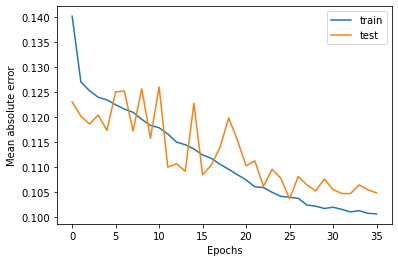

Root mean square error: 7766.654296875
MAPE: 0.19001265911881937
MAE: 5197.608044454319
R2 score: 0.6506771483448042
 
 
---------------------------------------------------
Train on 34815 samples, validate on 570 samples
Epoch 1/100
34815/34815 [==============================] - 5s 150us/sample - loss: 0.1414 - val_loss: 0.1468
Epoch 2/100
34815/34815 [==============================] - 2s 54us/sample - loss: 0.1263 - val_loss: 0.1346
Epoch 3/100
34815/34815 [==============================] - 2s 53us/sample - loss: 0.1245 - val_loss: 0.1428
Epoch 4/100
34815/34815 [==============================] - 2s 53us/sample - loss: 0.1230 - val_loss: 0.1333
Epoch 5/100
34815/34815 [==============================] - 2s 52us/sample - loss: 0.1228 - val_loss: 0.1378
Epoch 6/100
34815/34815 [==============================] - 2s 51us/sample - loss: 0.1219 - val_loss: 0.1307
Epoch 7/100
34815/34815 [==============================] - 2s 52us/sample - loss: 0.1210 - val_loss: 0.1324
Epoch 8/100
34815/3481

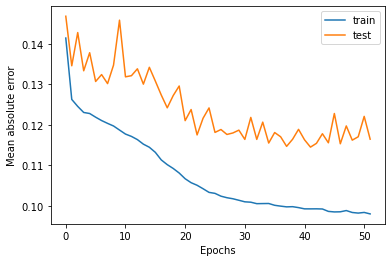

Root mean square error: 8358.48046875
MAPE: 0.18521555025154
MAE: 5745.3064573053725
R2 score: 0.6420461778207316
 
 
---------------------------------------------------
Train on 35385 samples, validate on 589 samples
Epoch 1/100
35385/35385 [==============================] - 5s 136us/sample - loss: 0.1423 - val_loss: 0.1260
Epoch 2/100
35385/35385 [==============================] - 2s 48us/sample - loss: 0.1276 - val_loss: 0.1201
Epoch 3/100
35385/35385 [==============================] - 2s 50us/sample - loss: 0.1253 - val_loss: 0.1171
Epoch 4/100
35385/35385 [==============================] - 2s 47us/sample - loss: 0.1242 - val_loss: 0.1175
Epoch 5/100
35385/35385 [==============================] - 2s 51us/sample - loss: 0.1232 - val_loss: 0.1188
Epoch 6/100
35385/35385 [==============================] - 2s 51us/sample - loss: 0.1228 - val_loss: 0.1191
Epoch 7/100
35385/35385 [==============================] - 2s 52us/sample - loss: 0.1212 - val_loss: 0.1181
Epoch 8/100
35385/35385 [

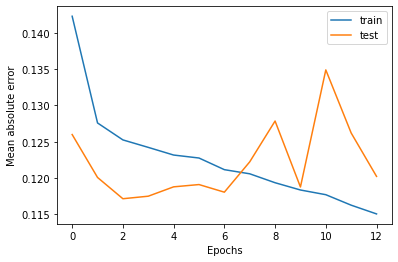

Root mean square error: 8889.69921875
MAPE: 0.19614418722040466
MAE: 5878.355559940047
R2 score: 0.5963802596330612
 
 
---------------------------------------------------


In [16]:
# Testing
# lag=14
ds=['october','november','december']

data_LSTM_X, data_LSTM_Y = sequence_data_build(data, lag)
totday=int(data_LSTM_X.shape[0]/20)
m1 = [totday-61, totday-31, totday, ]
m2 = [m1[0]-31, m1[1]-30, m1[2]-31, ]
for i in range(len(m1)):
    trainX, trainY, testX, testY = train_test_build(data_LSTM_X, data_LSTM_Y, m1[i], m2[i])
    testYcopy=testY
    saving = True
    EarlyStop = True
    rmse, mape, mae, r2, history = model_build(trainX, trainY, testX, testY, units, saving, ds[i], EarlyStop)
        
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Mean absolute error")
    pyplot.savefig("SM2F_" + ds[i] + ".png")
    pyplot.show()
    
    
    print("Root mean square error: {0}".format(rmse))
    print("MAPE: {0}".format(mape))
    print("MAE: {0}".format(mae))
    print("R2 score: {0}".format(r2))
    print(" ")
    print(" ")
    print("---------------------------------------------------")

In [17]:
print("lag vector")
print(lag_vec)
print("LSTM units")
print(units_vec)
print("Cross-validation results")
print(lag,units)
print("----------------------------")
print("RMSE")
print(results[0,:])

print("----------------------------")
print("MAE")
print(results[1,:])

print("----------------------------")
print("MAPE")
print(results[2,:])

print("----------------------------")
print("R2-score")
print(results[3,:])

lag vector
[7, 14]
LSTM units
[2, 4, 8, 16, 32, 64, 128]
Cross-validation results
14 128
----------------------------
RMSE
[[[9457.08691406 9514.91113281 9686.01757812 9489.01660156 9352.48242188
   9319.546875   9292.24511719]
  [7693.75927734 7854.38427734 7500.76074219 7687.37255859 7770.6015625
   7500.62304688 7443.32177734]]

 [[8254.93945312 8776.24023438 8449.4375     8568.25195312 8603.73535156
   8410.04101562 8514.86132812]
  [9054.84863281 9417.25390625 9863.85253906 8498.42773438 9329.83398438
   9467.63671875 8501.8984375 ]]

 [[7651.95996094 8043.68798828 8564.4453125  8267.90625    8247.70117188
   8159.40527344 8094.27783203]
  [9603.65429688 9188.77734375 9116.74804688 9058.38769531 8643.09277344
   8697.1953125  8714.25585938]]]
----------------------------
MAE
[[[0.66553177 0.67766316 0.67188573 0.66772661 0.67057594 0.68046078
   0.68574428]
  [0.18055446 0.19195683 0.15248012 0.16572908 0.16544066 0.17990643
   0.18375309]]

 [[0.17020935 0.19074789 0.18318555 0.1